# 数据分析

In [60]:
# Import Used Libs,添加需要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report


## 复制原文件建立新数据处理文件
帮助我们确保有迹可循，分析过程中不会直接影响之前的数据库（损坏或者更改）

In [61]:
# 读取源Excel文件
source_file_path = 'resources/German_credit.xlsx' 
df = pd.read_excel(source_file_path)
# 创建一个新的Excel文件并将数据写入其中
new_file_path = 'resources/German_credit_NEW.xlsx'
df.to_excel(new_file_path, index=False)
print(f'Data successfully copied to {new_file_path}')
# data现在是我们用来分析的源数据附件
data = pd.read_excel(new_file_path)

Data successfully copied to resources/German_credit_NEW.xlsx


## 指标筛检
先画图去了解数据变量内容，和形式，例如连续性，是与否等。这样我们后面进行主要变量的选择会更明确，模型会更贴切我们的问题和目标。


In [62]:
# 查看数据概况
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   Account Balance                    1000 non-null   int64
 1   Duration of Credit (month)         1000 non-null   int64
 2   Payment Status of Previous Credit  1000 non-null   int64
 3   Purpose                            1000 non-null   int64
 4   Credit Amount                      1000 non-null   int64
 5   Value Savings/Stocks               1000 non-null   int64
 6   Length of current employment       1000 non-null   int64
 7   Instalment per cent                1000 non-null   int64
 8   Sex & Marital Status               1000 non-null   int64
 9   Guarantors                         1000 non-null   int64
 10  Duration in Current address        1000 non-null   int64
 11  Most valuable available asset      1000 non-null   int64
 12  Age (years)          

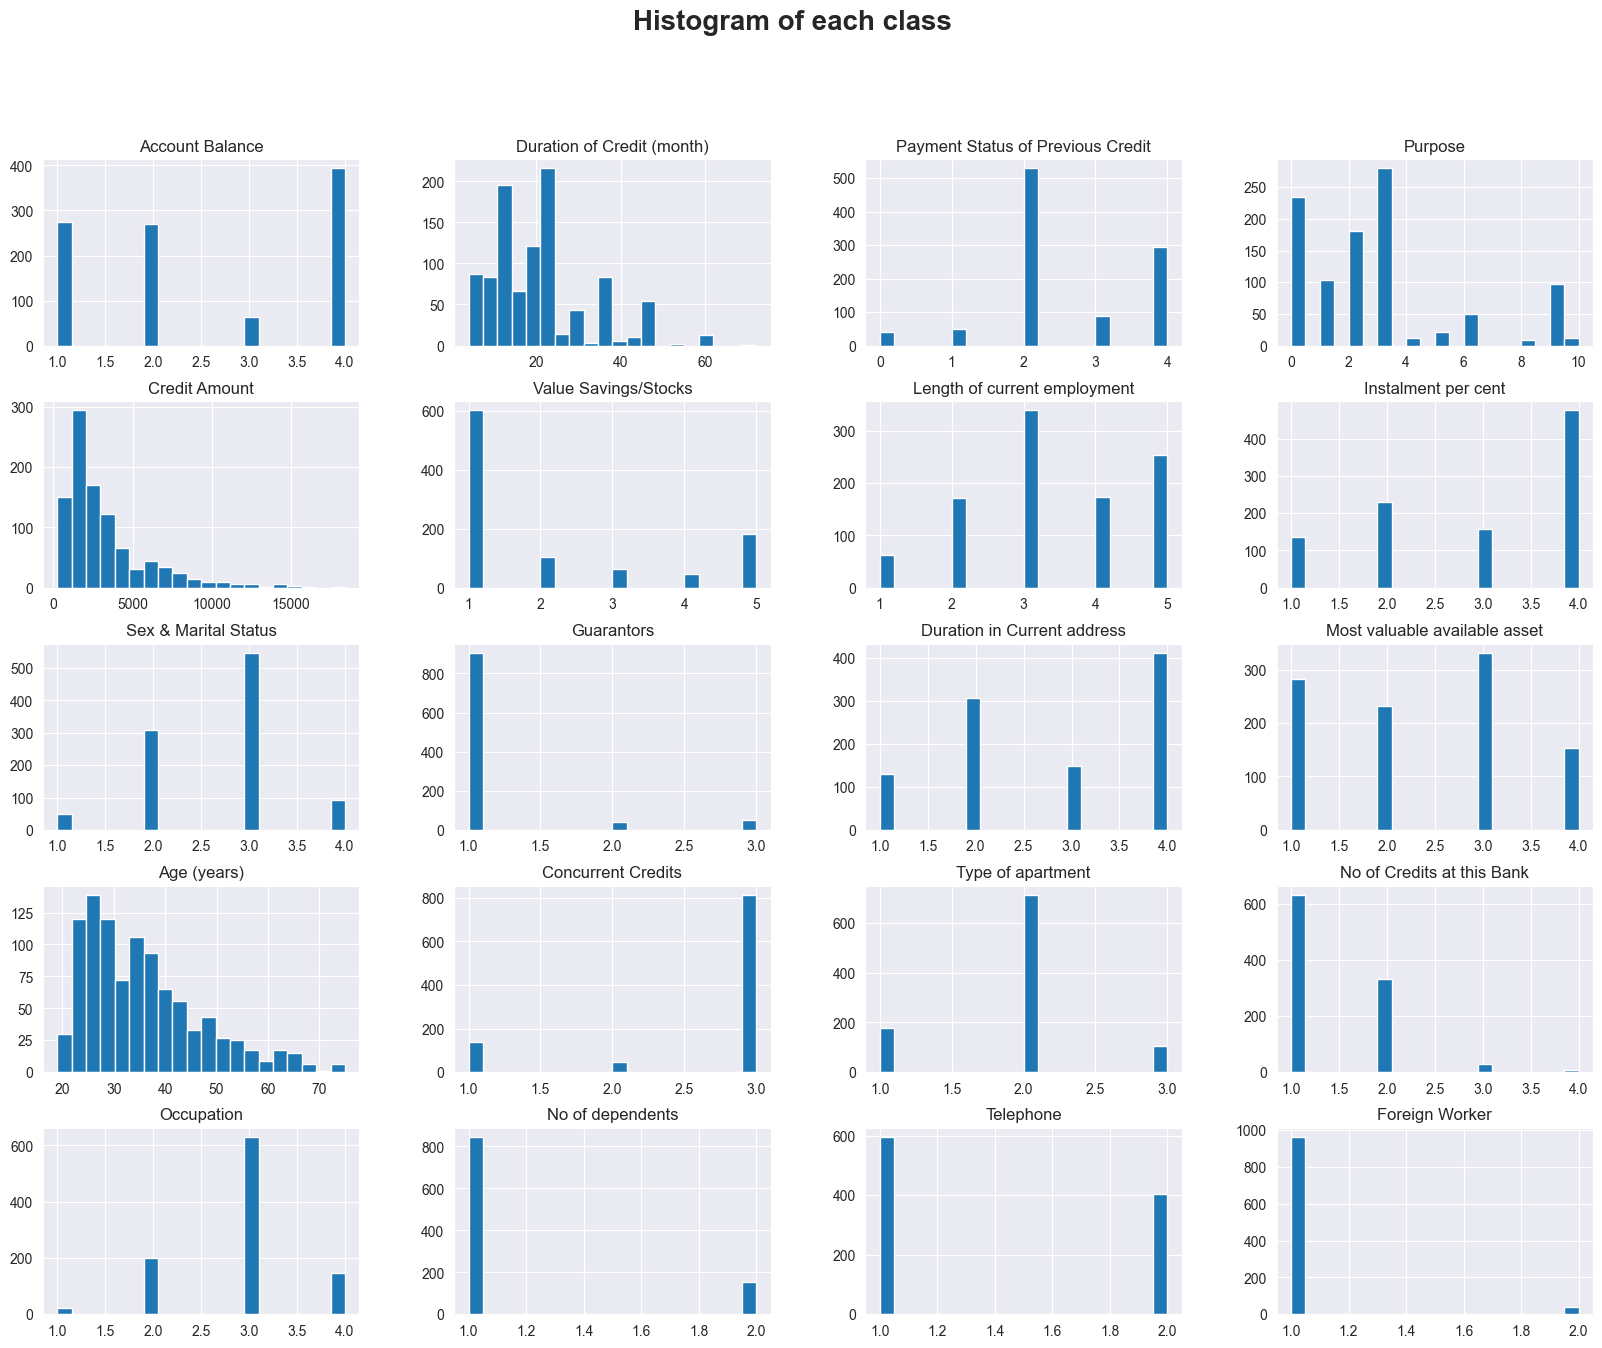

In [63]:
# 绘制数据直方图
def plot_histograms(df, columns):
    df[columns].hist(bins=20, figsize=(20, 15))
    plt.suptitle('Histogram of each class', fontsize= 20, fontweight='bold')
    plt.show()
plot_histograms(df, df.columns[:-1])


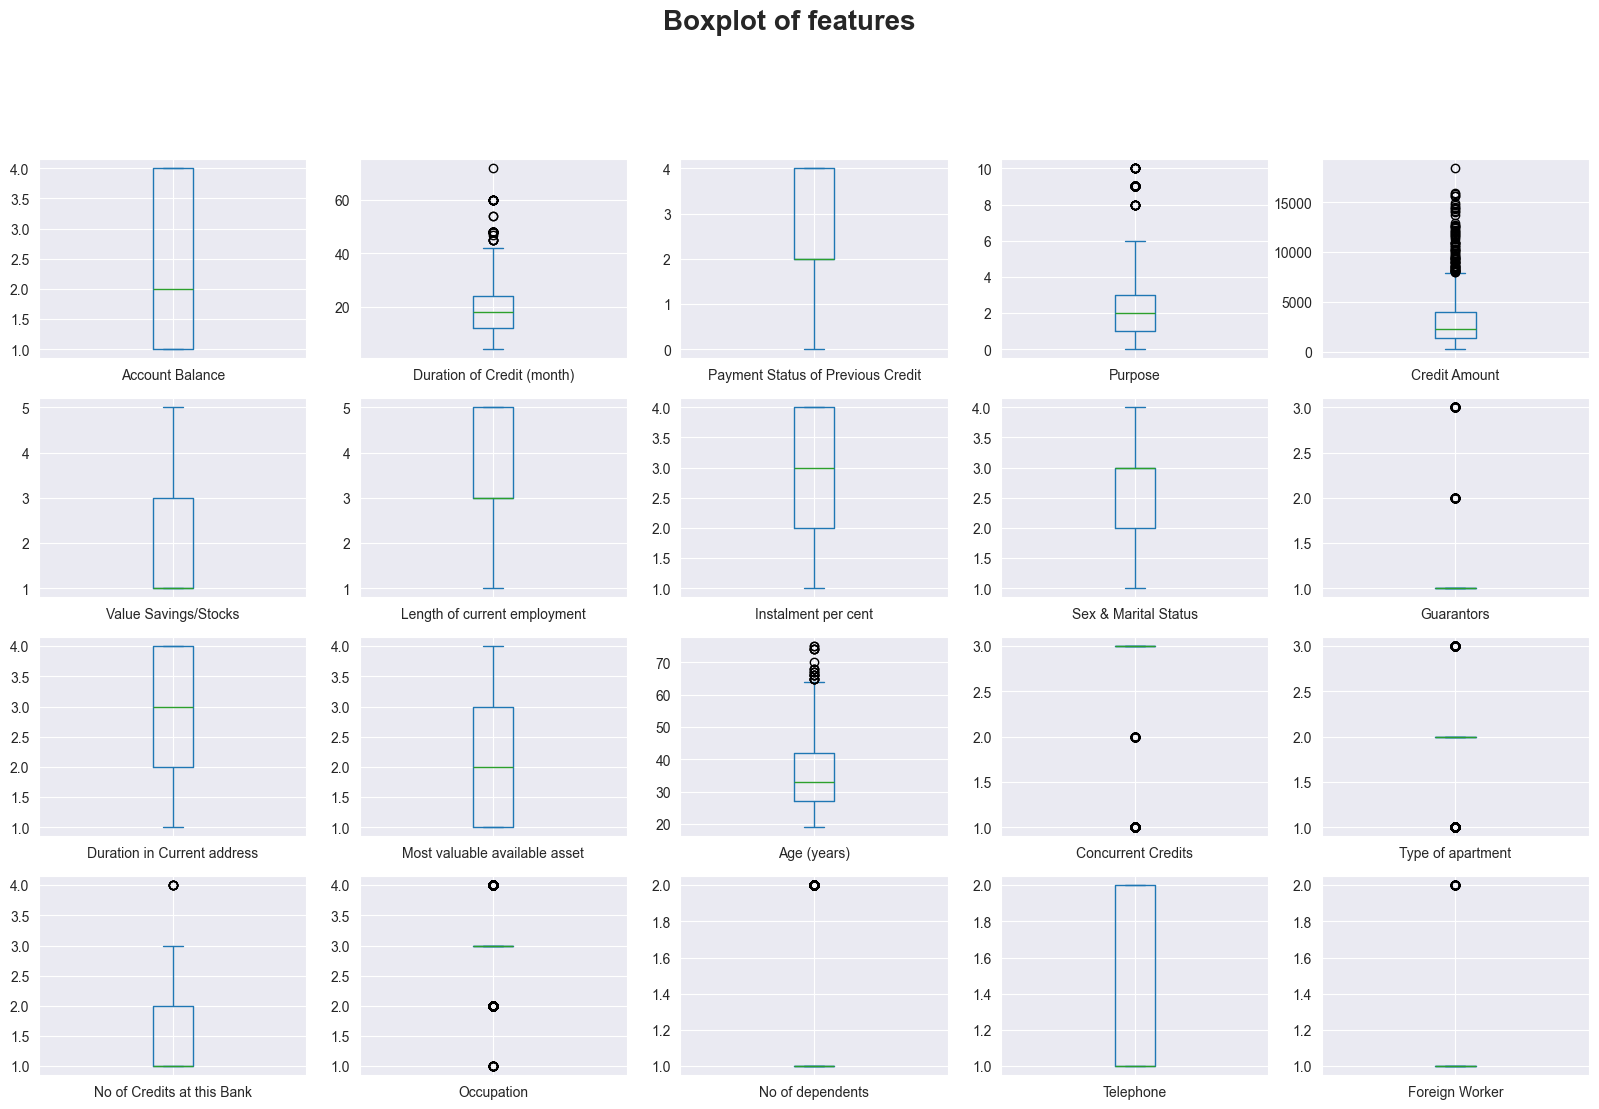

In [64]:
# 绘制数据箱线图
def plot_boxplots(df, columns):
    df[columns].plot(kind='box', subplots=True, layout=(5, 5), sharex=False, sharey=False,figsize=(20, 15))
    plt.suptitle('Boxplot of features', fontsize= 20, fontweight='bold')
    plt.show()
plot_boxplots(df, df.columns[:-1])


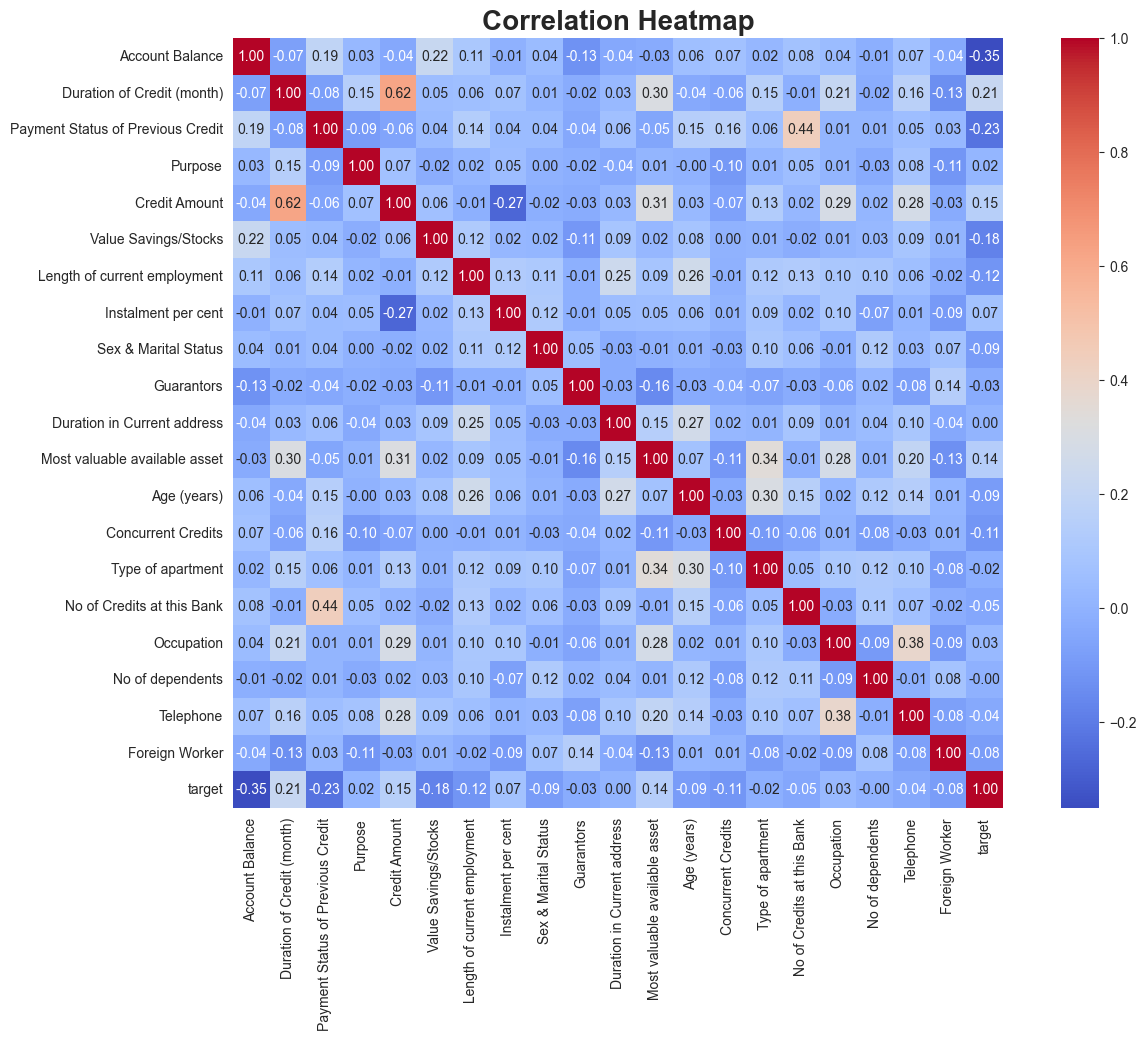

Top correlated features with target: ['Account Balance', 'Payment Status of Previous Credit', 'Duration of Credit (month)', 'Value Savings/Stocks', 'Credit Amount']


In [66]:
# 绘制数据相关性热图
def plot_correlation_heatmap(df):
    plt.figure(figsize=(15, 10))
    corr_matrix = df.corr()
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap= 'coolwarm', cbar=True, square=True)
    plt.title('Correlation Heatmap', fontsize= 20, fontweight='bold')
    plt.show()
plot_correlation_heatmap(df)
# 选择的影响力大的变量数量
numVar = 5
# 找到对target最有影响力的变量，依次排名，拿前五名
def find_top_correlated_features(df, target, n=numVar):
    corr_matrix = df.corr()
    target_corr = corr_matrix[target].abs().sort_values(ascending=False)
    top_features = target_corr.index[1:n+1]  # 排除掉target本身
    return top_features, target_corr

selected_features_CHMap, target_corr = find_top_correlated_features(df, 'target', n=5)
print(f'Top correlated features with target: {selected_features_CHMap.tolist()}')
# print(f'Correlation values: {target_corr[top_features].values}')

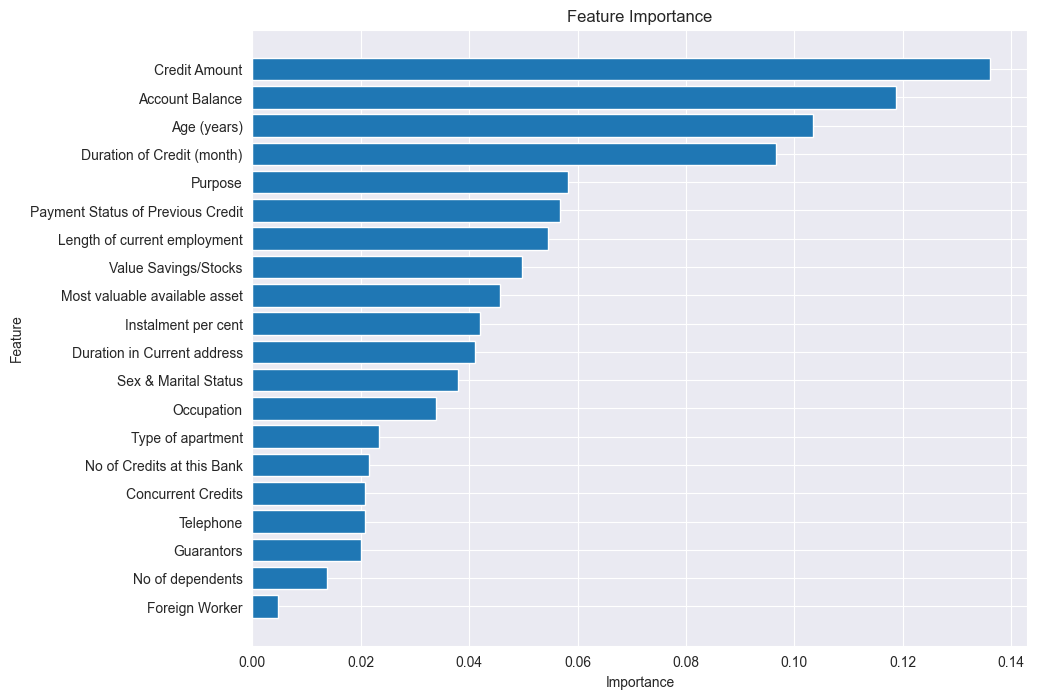

Top correlated features with target: ['Credit Amount', 'Account Balance', 'Age (years)', 'Duration of Credit (month)', 'Purpose']


In [69]:
# 绘制随机森林模型相关图

# 特征选择和目标变量
features = data.columns[data.columns != 'target'] 
target = 'target'
# 分割数据集
X = data[features]
y = data[target]
# 构建随机森林模型以评估特征重要性
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)
# 获取特征重要性
importances = rf.feature_importances_
feature_importances = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
# 可视化特征重要性
plt.figure(figsize=(10, 8))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()
# 筛选重要性较高的变量，前五名
selected_features_rf = feature_importances.nlargest(5, 'Importance')['Feature']
print(f'Top correlated features with target: {selected_features_rf.tolist()}')

## 数据分箱 （Binning）

 - Binning：
    - **n_bins**: 箱子数量

    - **strategy**: 
        - 'uniform': 每个箱宽度相等
        - 'quantile': 按照等频分箱，每个箱中的数据点数量相同
        - 'kmeans'：使用K-means分箱，根据数据点分布自动确定箱。更智能
        
- WOE: Weight of Evidence

- IV: Information Value

In [52]:
# 分箱函数
def binning(data, column, n_bins, strategy='kmeans'):  
    # 减少分箱数量并更改策略
    est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy=strategy)
    data[column + '_binned'] = est.fit_transform(data[[column]])
    return data, est

# 计算WOE函数
def calculate_woe(data, column, target):
    woe_dict = {}
    iv = 0
    total_good = sum(data[target] == 0)
    total_bad = sum(data[target] == 1)
    
    for bin in sorted(data[column].unique()):
        bin_data = data[data[column] == bin]
        good = sum(bin_data[target] == 0)
        bad = sum(bin_data[target] == 1)
        good_dist = good / total_good
        bad_dist = bad / total_bad
        # Default Value of bad_dist when it is 0 is 0.5
        woe = np.log(good_dist / bad_dist) if bad_dist != 0 else np.log(good_dist / 0.5)

        woe_dict[bin] = woe
        iv += (good_dist - bad_dist) * woe
    
    return woe_dict, iv

# 特征选择和目标变量
columns_to_bin = ['Account Balance', 'Duration of Credit (month)', 'Credit Amount', 'Payment Status of Previous Credit']
target_column = 'target'

# 分箱和 WOE 计算
results = {}
woe_iv_values = {}
for n_bins in [2, 3, 4]:
    df_copy = df.copy()
    woe_iv_values[n_bins] = {}
    for column in columns_to_bin:
        df_copy, binning_estimator = binning(df_copy, column, n_bins)
        woe_dict, iv = calculate_woe(df_copy, column + '_binned', target_column)
        df_copy[column + '_woe'] = df_copy[column + '_binned'].map(woe_dict)
        woe_iv_values[n_bins][column] = {'woe': woe_dict, 'iv': iv}
    
    # 模型训练和验证
    X = df_copy[[col + '_woe' for col in columns_to_bin]]
    y = df_copy[target_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    results[n_bins] = auc

print("AUC scores for different binning numbers:", results)

# 打印每个特征的 WOE 和 IV 值
for n_bins, columns in woe_iv_values.items():
    print(f"\nBinning number: {n_bins}")
    for column, values in columns.items():
        print(f"Feature: {column}")
        print(f"WOE values: {values['woe']}")
        print(f"IV value: {values['iv']}")

AUC scores for different binning numbers: {2: 0.7127976190476191, 3: 0.714345238095238, 4: 0.7310119047619048}

Binning number: 2
Feature: Account Balance
WOE values: {0.0: -0.6142039782198259, 1.0: 1.0422938580778862}
IV value: 0.6081713484693029
Feature: Duration of Credit (month)
WOE values: {0.0: 0.20424691742292023, 1.0: -0.6428853457790568}
IV value: 0.12989361369096977
Feature: Credit Amount
WOE values: {0.0: 0.11861810877380505, 1.0: -0.5088434625619993}
IV value: 0.060057036113569835
Feature: Payment Status of Previous Credit
WOE values: {0.0: -1.2340708354832153, 1.0: 0.1415959524612531}
IV value: 0.17228588820447388

Binning number: 3
Feature: Account Balance
WOE values: {0.0: -0.8180987056949414, 1.0: -0.4013917827205285, 2.0: 1.0422938580778862}
IV value: 0.6348108973266989
Feature: Duration of Credit (month)
WOE values: {0.0: 0.21532082563300065, 1.0: -0.6114691495456782, 2.0: -0.8472978603872037}
IV value: 0.13469884784829947
Feature: Credit Amount
WOE values: {0.0: 0.20

In [48]:
# # 需要进行分箱的列
# columns_to_bin = ['Account Balance', 'Duration of Credit (month)', 'Credit Amount', 'Payment Status of Previous Credit']
# target_column = 'target'
# 
# 
# # 对每个列进行分箱和计算WOE
# for column in columns_to_bin:
#     data, binning_estimator = binning(data, column)
#     woe_dict, iv = calculate_woe(data, column + '_binned', target_column)
#     data[column + '_woe'] = data[column + '_binned'].map(woe_dict)
#     print(f"WOE values for {column}: {woe_dict}")
#     print(f"IV value for {column}: {iv}")
#     print("------------------------------")
# 
# # 显示结果
# print(df.head())

WOE values for Account Balance: {0.0: -0.8180987056949414, 1.0: -0.4013917827205285, 2.0: 1.0422938580778862}
IV value for Account Balance: 0.6348108973266989
------------------------------
WOE values for Duration of Credit (month): {0.0: 0.21532082563300065, 1.0: -0.6114691495456782, 2.0: -0.8472978603872037}
IV value for Duration of Credit (month): 0.13469884784829947
------------------------------
WOE values for Credit Amount: {0.0: 0.2022678209763335, 1.0: -0.3722394604798439, 2.0: -1.1032312345244042}
IV value for Credit Amount: 0.134187159696215
------------------------------
WOE values for Payment Status of Previous Credit: {0.0: -1.2340708354832153, 1.0: -0.08831861697739624, 2.0: 0.5097261184325739}
IV value for Payment Status of Previous Credit: 0.2468681297242141
------------------------------
   Account Balance  Duration of Credit (month)  \
0                1                          18   
1                1                           9   
2                2                

column_to_bin：

定义：这是您希望进行分箱处理的特征列。通常，这列是一个连续变量或有序的离散变量。
选择方法：选择一个您认为对目标变量有显著影响的特征列。例如，如果您正在进行信用评分分析，您可能会选择“贷款金额”、“年龄”或“信用期限”等列。
target_column：

定义：这是您的目标变量列，通常是一个二分类变量（0/1，或者是其他两种状态），用于监督学习。
选择方法：选择一个表示您感兴趣的结果的列。例如，如果您正在分析信用风险数据，目标列可能是“是否违约”（1表示违约，0表示未违约）。

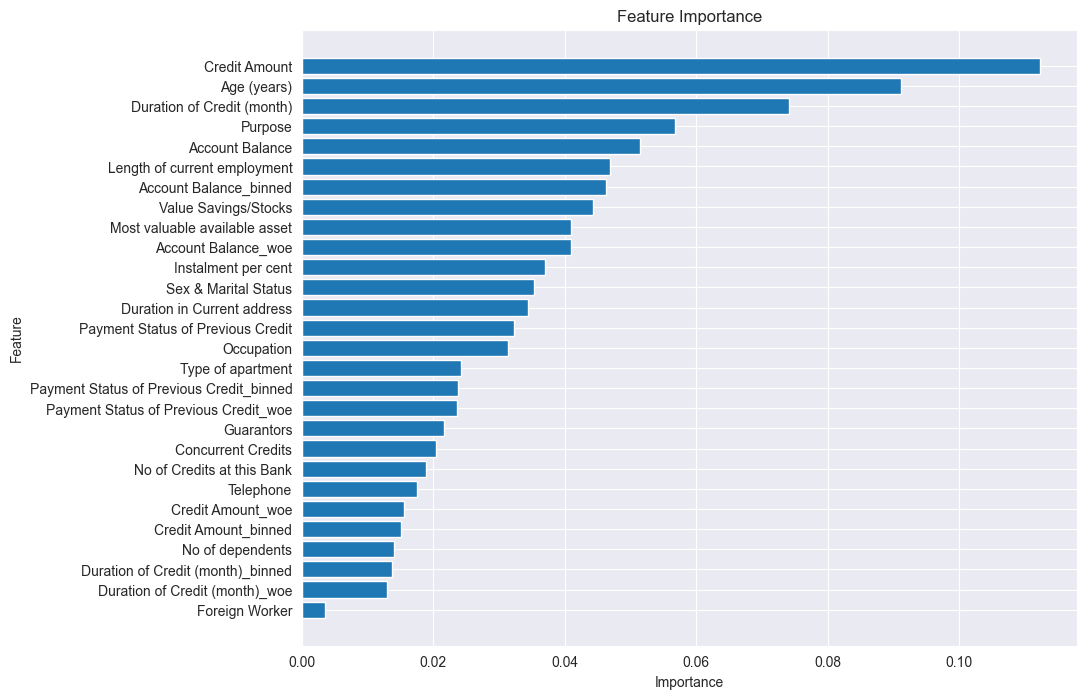

Selected features: ['Credit Amount', 'Age (years)', 'Duration of Credit (month)', 'Purpose', 'Account Balance', 'Length of current employment', 'Account Balance_binned', 'Value Savings/Stocks', 'Most valuable available asset', 'Account Balance_woe']


## 模型构造与验证

In [43]:
# 特征选择
features = ['Account Balance', 'Duration of Credit (month)', 'Credit Amount']  # 替换为实际特征列
target = 'target'

# 分割数据集为训练集和测试集
X = data[selected_features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 对数据进行标准化处理
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 建立逻辑回归模型
model = LogisticRegression(max_iter=10000, C=1.0, penalty='l2', solver='lbfgs')

# 交叉验证
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
print(f'Cross-validated AUC scores: {cv_scores}')
print(f'Mean AUC score: {np.mean(cv_scores)}')

# 在训练集上训练模型
model.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# 评估模型性能
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'AUC: {roc_auc_score(y_test, y_pred_proba)}')
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))

Cross-validated AUC scores: [0.77085295 0.73507814 0.78329613 0.73195685 0.77176339]
Mean AUC score: 0.7585894910944042
Accuracy: 0.745
AUC: 0.7706872370266481
Confusion Matrix:
[[127  11]
 [ 40  22]]
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.92      0.83       138
           1       0.67      0.35      0.46        62

    accuracy                           0.74       200
   macro avg       0.71      0.64      0.65       200
weighted avg       0.73      0.74      0.72       200


In [ ]:
# 定义参数网格进行调优
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],  # 使用l1和l2正则化
    'solver': ['liblinear']   # 由于l1正则化只适用于某些solver
}

# 使用GridSearchCV进行超参数调优
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

# 输出最优参数
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best cross-validated AUC: {grid_search.best_score_}')

# 使用最优参数建立模型
best_model = grid_search.best_estimator_

# 在测试集上进行预测
y_pred_optimized = best_model.predict(X_test)
y_pred_proba_optimized = best_model.predict_proba(X_test)[:, 1]

# 评估优化后的模型性能
print(f'Optimized Accuracy: {accuracy_score(y_test, y_pred_optimized)}')
print(f'Optimized AUC: {roc_auc_score(y_test, y_pred_proba_optimized)}')
print('Optimized Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_optimized))
print('Optimized Classification Report:')
print(classification_report(y_test, y_pred_optimized))

In [ ]:
# 使用 class_weight='balanced' 的逻辑回归模型
best_model = LogisticRegression(C=1, penalty='l2', solver='liblinear', class_weight='balanced')
best_model.fit(X_train, y_train)

# 在测试集上进行预测
y_pred_optimized = best_model.predict(X_test)
y_pred_proba_optimized = best_model.predict_proba(X_test)[:, 1]

# 评估优化后的模型性能
print(f'Optimized Accuracy: {accuracy_score(y_test, y_pred_optimized)}')
print(f'Optimized AUC: {roc_auc_score(y_test, y_pred_proba_optimized)}')
print('Optimized Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_optimized))
print('Optimized Classification Report:')
print(classification_report(y_test, y_pred_optimized))


In [ ]:
# 构建随机森林模型
rf_model = RandomForestClassifier(random_state=42)

# 交叉验证评估模型性能
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='roc_auc')
print(f'Cross-validated AUC scores: {cv_scores}')
print(f'Mean AUC score: {np.mean(cv_scores)}')

# 在训练集上训练模型
rf_model.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# 评估模型性能
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'AUC: {roc_auc_score(y_test, y_pred_proba)}')
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))

In [ ]:
# 随机森林
# 定义参数网格进行调优
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# 使用GridSearchCV进行超参数调优
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# 输出最优参数
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best cross-validated AUC: {grid_search.best_score_}')

# 使用最优参数建立模型
best_rf_model = grid_search.best_estimator_

# 在测试集上进行预测
y_pred_optimized = best_rf_model.predict(X_test)
y_pred_proba_optimized = best_rf_model.predict_proba(X_test)[:, 1]

# 评估优化后的模型性能
print(f'Optimized Accuracy: {accuracy_score(y_test, y_pred_optimized)}')
print(f'Optimized AUC: {roc_auc_score(y_test, y_pred_proba_optimized)}')
print('Optimized Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_optimized))
print('Optimized Classification Report:')
print(classification_report(y_test, y_pred_optimized))

## 评分卡和模型建立

In [ ]:
# 定义评分卡参数
base_score = 600  # 基础分数
pdo = 50  # 赔率翻倍分数
factor = pdo / np.log(2)
offset = base_score - factor * np.log(1 / 1)  # 设置为基准分数

# 获取模型输出的概率
y_pred_proba = best_rf_model.predict_proba(X_test)[:, 1]

# 将概率转换为评分
def probability_to_score(prob, factor, offset):
    return np.round(offset + factor * np.log(prob / (1 - prob)))

# 计算评分
scores = probability_to_score(y_pred_proba, factor, offset)

# 添加到测试集数据中
X_test['score'] = scores
X_test['actual'] = y_test

# 显示前几行结果
print(X_test.head())